In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/carl')

In [7]:
theta = [[ 0.0230769230769, -0.253846153846 ],
         [-0.0230769230769, -0.853846153846 ],
         [ 0.0692307692308, -0.0692307692308],
         [ 0.0692307692308,  0.207692307692 ],
         [-0.115384615385,  -0.9            ],
         [-0.161538461538,   0.346153846154 ],
         [-0.207692307692,   0.0230769230769],
         [-0.207692307692,   0.669230769231 ],
         [ 0.253846153846,   0.253846153846 ],
         [-0.253846153846,  -0.3            ],
         [ 0.253846153846,   0.853846153846 ],
         [-0.346153846154,   0.9            ],
         [-0.3,              0.115384615385 ],
         [ 0.3,             -0.115384615385 ],
         [ 0.3,             -0.484615384615 ],
         [ 0.3,              0.761538461538 ],
         [-0.438461538462,  -0.484615384615 ],
         [ 0.438461538462,  -0.853846153846 ],
         [ 0.530769230769,  -0.0230769230769],
         [ 0.530769230769,   0.253846153846 ],
         [-0.530769230769,   0.3            ],
         [-0.576923076923,  -0.9            ],
         [-0.623076923077,  -0.161538461538 ],
         [-0.623076923077,   0.669230769231 ],
         [ 0.669230769231,  -0.669230769231 ],
         [ 0.761538461538,   0.392307692308 ],
         [-0.761538461538,  -0.761538461538 ],
         [ 0.761538461538,  -0.761538461538 ],
         [-0.807692307692,   0.0230769230769],
         [-0.807692307692,   0.161538461538 ]]

theta = np.array(theta)

feature_names = ["minDelR_jZ", "DelPhi_Hjj", "DelEta_Hjj", "DelPhi_jj", "DelR_jj", 
                 "DelY_jj", "Mjj", "DelPt_jj", "DelPt_ZZ", "pT_Hjj", "Mjets", "Zeppetaj3", 
                 "ZeppetaZZ", "njets","Z1_E","Z1_pt","Z1_eta","Z1_phi","Z1_m","Z2_E","Z2_pt",
                 "Z2_eta","Z2_phi","Z2_m",  "higgs_E","higgs_pt","higgs_eta","higgs_phi","higgs_m", 
                 "jet1_E","jet1_eta","jet1_y","jet1_phi","jet1_pt","jet1_m","jet2_E", "jet2_eta","jet2_y", 
                 "jet2_phi","jet2_pt","jet2_m","jet3_E","jet3_eta","jet3_y" ,"jet3_phi","jet3_pt","jet3_m"]

# subset = [3]  #DelPhi_jj
# subset = [33] #jet1_pt
#subset = [33, 3]
#subset = [3, 4, 6, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 30, 33, 34, 36, 39, 40]
subset = list(range(len(feature_names)))

In [8]:
base_dir = "/afs/cern.ch/work/j/jpavezse/public/samples_cyril/data/"

In [9]:
import carl

In [10]:
observed = 8
X_observed = np.loadtxt(base_dir + "data_%d.dat" % observed)[:, subset]
X_observed.shape

# ideally, X_observed should be an independent sample not used for training

(204055, 47)

In [15]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedShuffleSplit


def make_ratio(num, den):
    X_num = np.loadtxt(base_dir + "data_%d.dat" % num)[:50000, subset]
    X_den = np.loadtxt(base_dir + "data_%d.dat" % den)[:50000, subset]
    X = np.vstack((X_num, X_den))
    y = np.zeros(len(X), dtype=np.int)
    y[len(X_num):] = 1

    clf = ExtraTreesClassifier(n_estimators=100, min_samples_split=20, random_state=0, n_jobs=-1)
    cv =  StratifiedShuffleSplit(n_iter=3, test_size=0.5, random_state=1)

    ratio = ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=25),
        random_state=0)
    ratio.fit(X, y)
    
    return ratio


def fisher(X_observed, ratio):
    w = ratio.predict(X_observed)
    return np.arccos(np.sum(np.sqrt(w)) / w.size)

# Pairwise distributions of the features

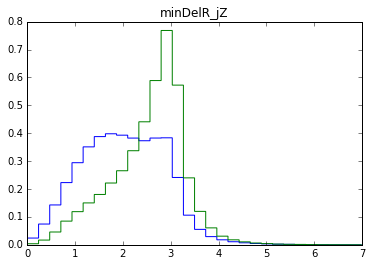

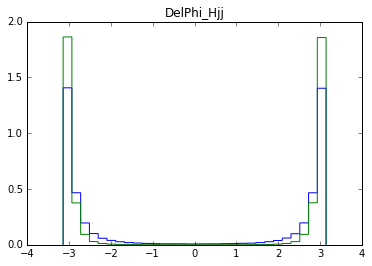

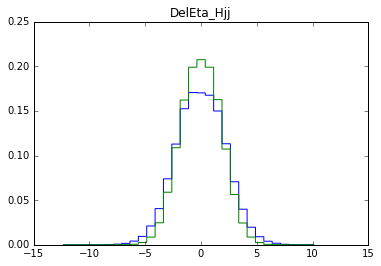

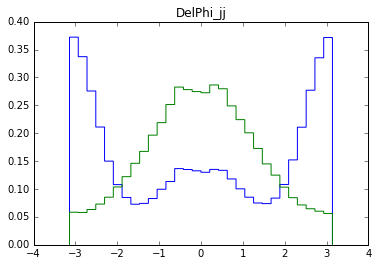

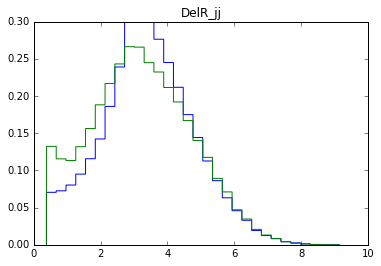

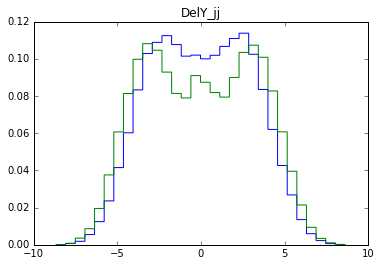

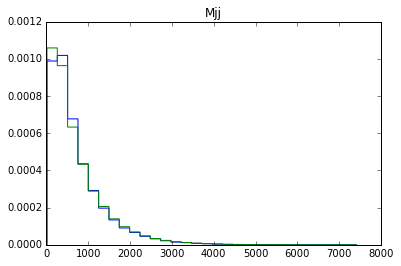

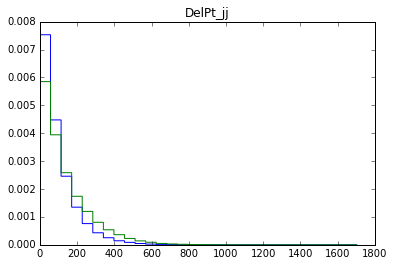

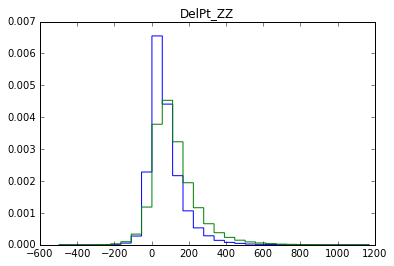

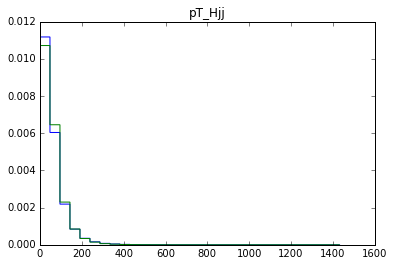

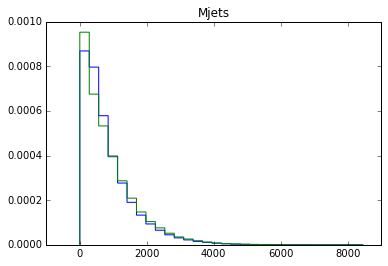

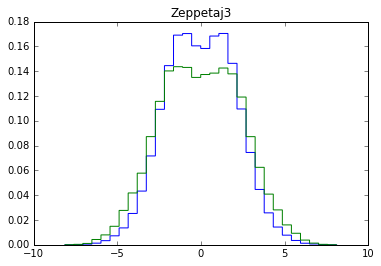

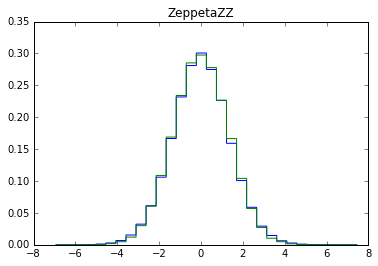

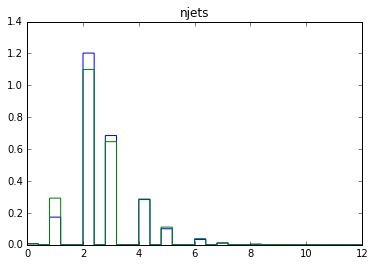

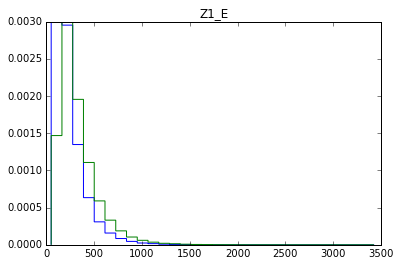

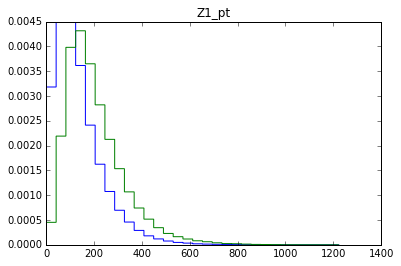

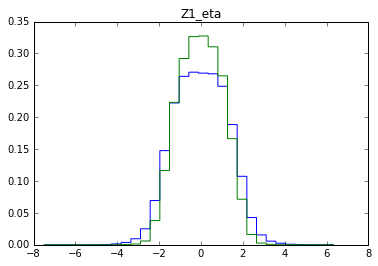

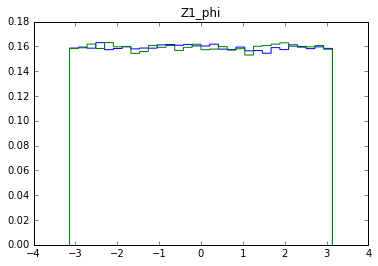

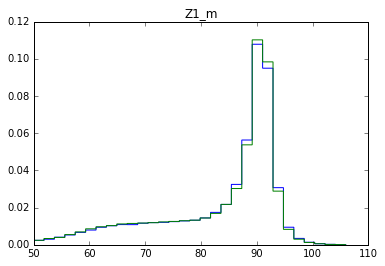

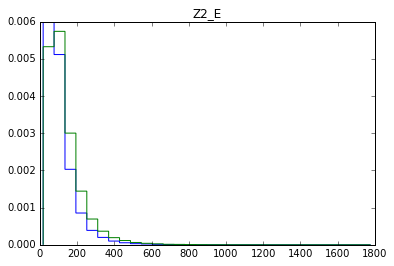

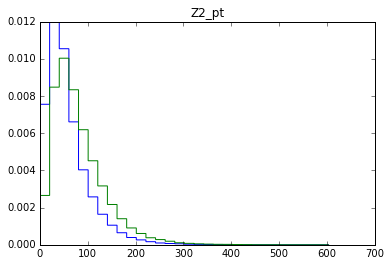

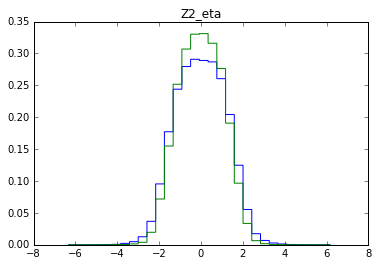

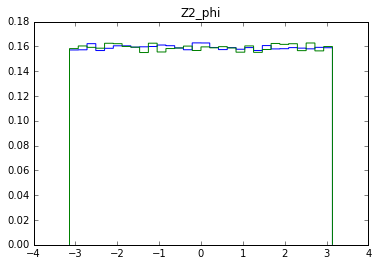

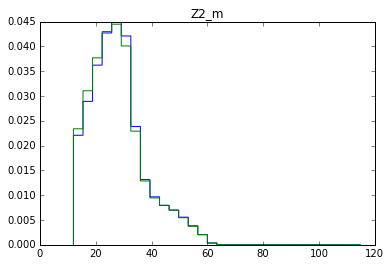

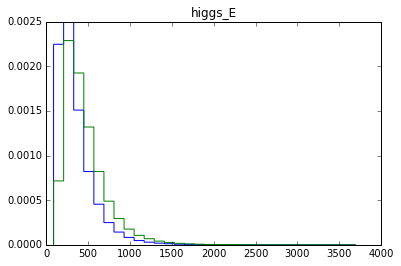

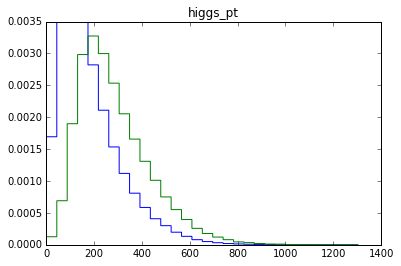

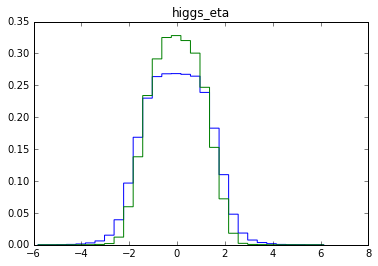

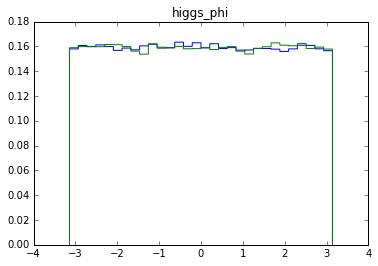

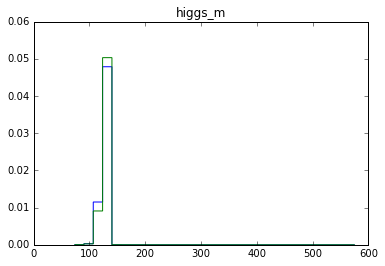

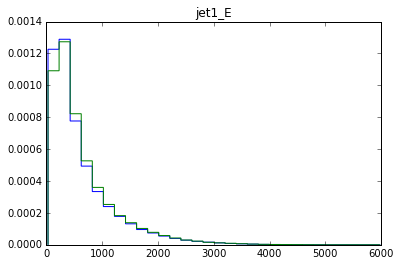

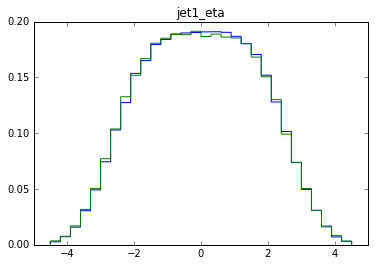

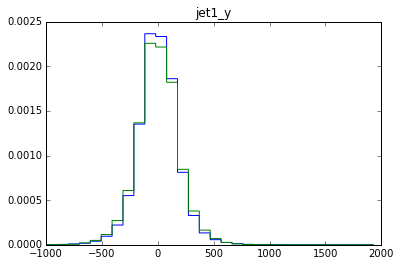

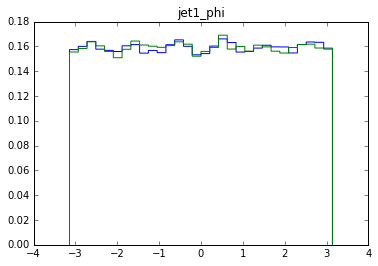

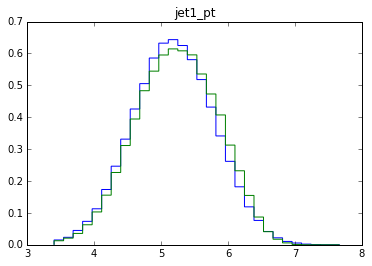

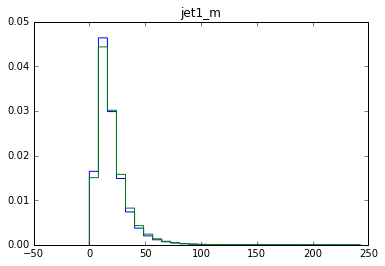

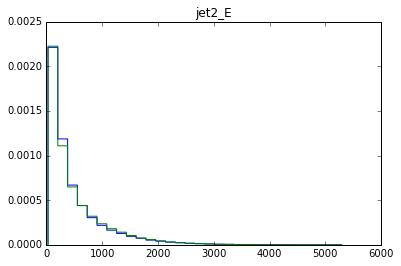

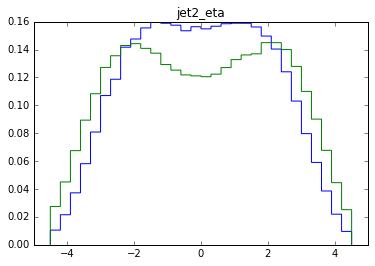

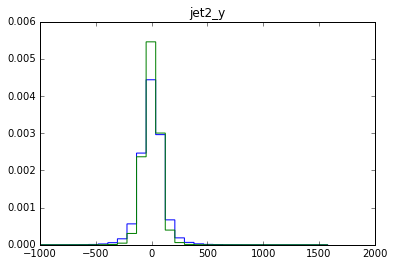

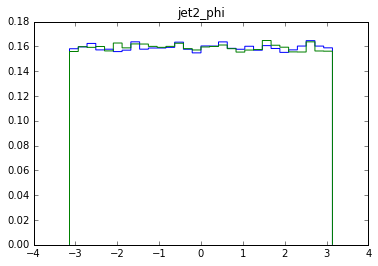

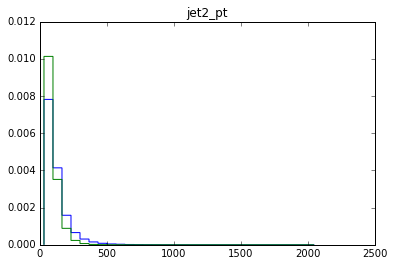

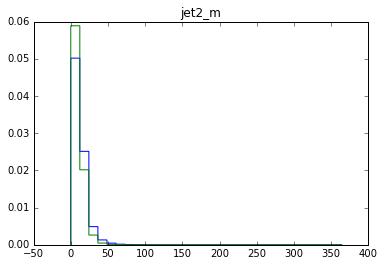

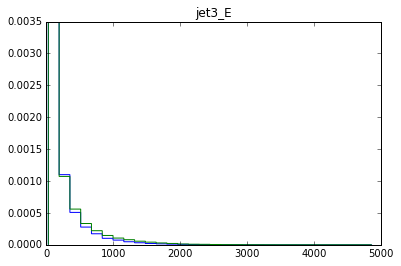

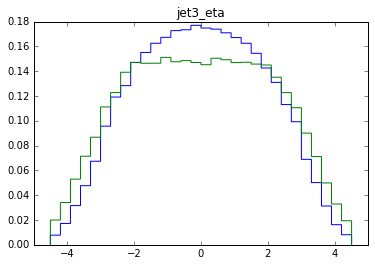

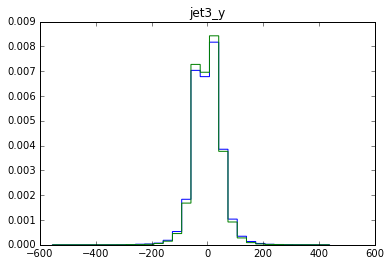

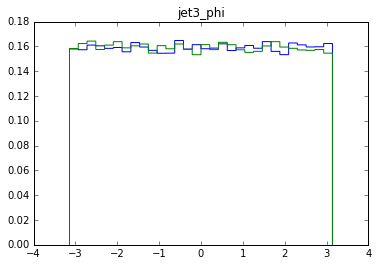

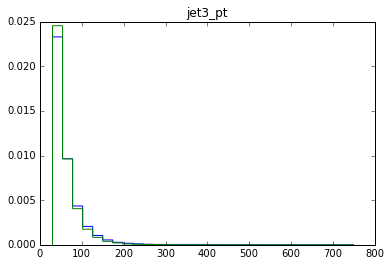

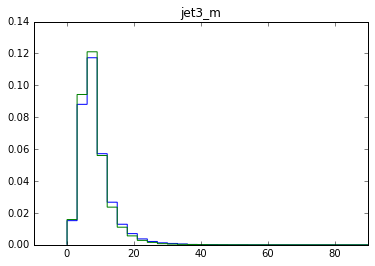

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

num = 0
#[ 0.0692307692308, -0.0692307692308]
den = 29
#[-0.346153846154,   0.9            ]
X_num = np.loadtxt(base_dir + "data_%d.dat" % num)
X_den = np.loadtxt(base_dir + "data_%d.dat" % den)

for j in range(X_num.shape[1]):
    plt.title(feature_names[j])
    
    val_num = [v for v in X_num[:, j] if v > -999]
    val_den = [v for v in X_den[:, j] if v > -999]
    if j == 33:
        val_num = np.log(val_num)
        val_den = np.log(val_den)
    vmin = min(np.min(val_num), np.min(val_den))
    vmax = max(np.max(val_num), np.max(val_den))
    
    plt.hist(val_num, range=(vmin, vmax), bins=30, normed=1, histtype="step")
    plt.hist(val_den, range=(vmin, vmax), bins=30, normed=1, histtype="step")
    plt.show()

In [ ]:
num = 0
den = 29
ratio = make_ratio(num, den)
X = np.loadtxt(base_dir + "data_%d.dat" % num)
plt.hist(ratio.classifier_.predict_proba(X)[:, 0], bins=50, histtype="step", label="p_x=0(s(x))")
X = np.loadtxt(base_dir + "data_%d.dat" % den)
plt.hist(ratio.classifier_.predict_proba(X)[:, 0], bins=50, histtype="step", label="p_x=23(s(x))")
plt.hist(ratio.classifier_.predict_proba(X_observed)[:, 0], bins=50, histtype="step", label="p_x=obs(s(x))")
plt.legend()
plt.show()

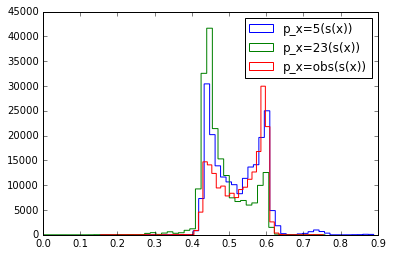

In [17]:
num = 5
den = 23
ratio = make_ratio(num, den)
X = np.loadtxt(base_dir + "data_%d.dat" % num)
plt.hist(ratio.classifier_.predict_proba(X)[:, 0], bins=50, histtype="step", label="p_x=5(s(x))")
X = np.loadtxt(base_dir + "data_%d.dat" % den)
plt.hist(ratio.classifier_.predict_proba(X)[:, 0], bins=50, histtype="step", label="p_x=23(s(x))")
plt.hist(ratio.classifier_.predict_proba(X_observed)[:, 0], bins=50, histtype="step", label="p_x=obs(s(x))")
plt.legend()
plt.show()

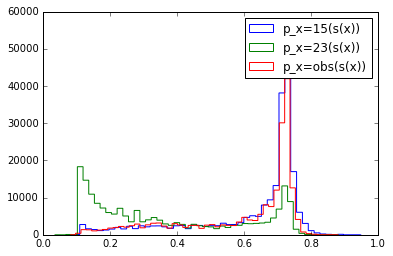

In [18]:
num = 15
den = 23
ratio = make_ratio(num, den)
X = np.loadtxt(base_dir + "data_%d.dat" % num)
plt.hist(ratio.classifier_.predict_proba(X)[:, 0], bins=50, histtype="step", label="p_x=15(s(x))")
X = np.loadtxt(base_dir + "data_%d.dat" % den)
plt.hist(ratio.classifier_.predict_proba(X)[:, 0], bins=50, histtype="step", label="p_x=23(s(x))")
plt.hist(ratio.classifier_.predict_proba(X_observed)[:, 0], bins=50, histtype="step", label="p_x=obs(s(x))")
plt.legend()
plt.show()